In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm
import os
import wfdb

In [5]:
ecg_path = '/Users/xushijian/Desktop/xushijian/side_projects/ECG_data/ptb-xl/1.0.3/records100/00000/00001_lr'

## Read ECG Raw Data

In [10]:
ecg_data = wfdb.rdsamp(ecg_path)
ecg_sig, ecg_meta = ecg_data[0], ecg_data[1]
ecg_sig.shape, ecg_meta.keys()

((1000, 12),
 dict_keys(['fs', 'sig_len', 'n_sig', 'base_date', 'base_time', 'units', 'sig_name', 'comments']))

## Preprocessing

In [13]:
from scipy.signal import butter, lfilter, filtfilt, iirnotch

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def notch_filter(data, freq, fs, Q=30):
    nyq = 0.5 * fs
    freq = freq / nyq
    b, a = iirnotch(freq, Q)
    y = filtfilt(b, a, data)
    return y

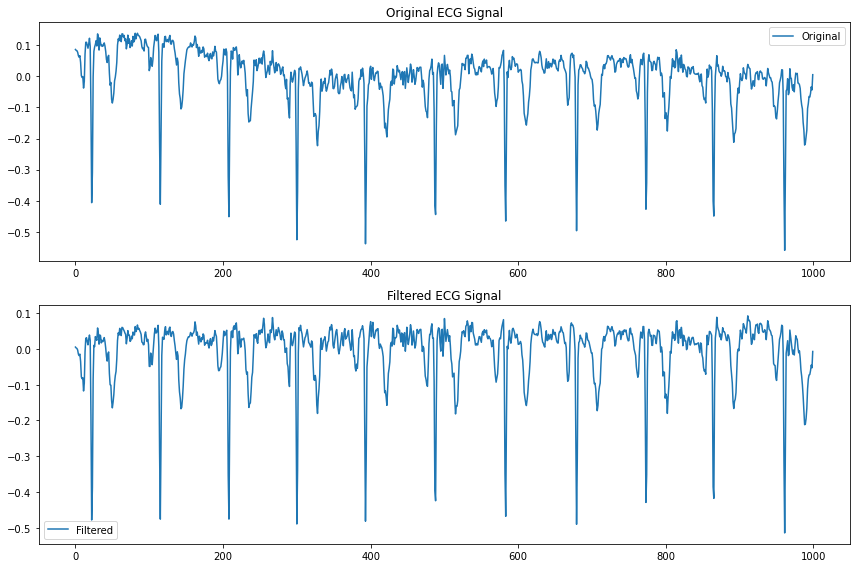

In [19]:
ecg_ch = 3

# Sampling rate
fs = 100  # Updated based on your data

# Apply bandpass filter
lowcut = 0.5
highcut = 40  # Reduced upper cutoff due to the lower sampling rate
ecg_filtered = butter_bandpass_filter(ecg_sig[:, ecg_ch], lowcut, highcut, fs, order=4)

# Apply notch filter at 50 Hz (adjust this if you are in a region with 60 Hz)
freq = 50  # Adjust this based on local power line frequency
ecg_filtered = notch_filter(ecg_filtered, freq, fs)

# Plot original and filtered signals
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(ecg_sig[:, ecg_ch], label='Original')
plt.title('Original ECG Signal')
plt.legend()
plt.subplot(212)
plt.plot(ecg_filtered, label='Filtered')
plt.title('Filtered ECG Signal')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# 初始化一个新的数组，用于存储所有处理后的信号
filtered_ecg_signals = np.zeros_like(ecg_sig)

# 对每个通道进行处理
for i in range(ecg_sig.shape[1]):  # 假设ecg_sig的第二维是通道维
    # 应用带通滤波器
    temp_filtered = butter_bandpass_filter(ecg_sig[:, i], lowcut, highcut, fs, order=4)
    # 应用陷波滤波器
    filtered_ecg_signals[:, i] = notch_filter(temp_filtered, freq, fs)

filtered_ecg_signals.shape

(1000, 12)

## Extract Meaningful Feature

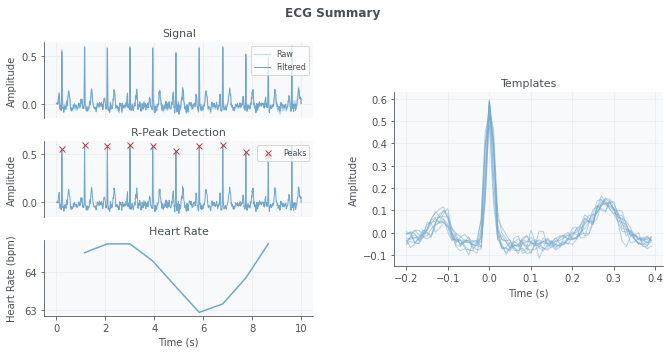

In [24]:
from biosppy.signals import ecg as ecg_biosppy

# 选择要分析的信号通道（通常选择导联II，但需要根据数据集具体情况调整）
channel_index = 0  # 根据需要调整通道
signal = filtered_ecg_signals[:, channel_index]
sampling_rate = 100  # PTB-XL数据集的采样频率

# 使用BioSPPy进行ECG分析
out = ecg_biosppy.ecg(signal=signal, sampling_rate=sampling_rate, show=True)

平均心率: 64.07 bpm


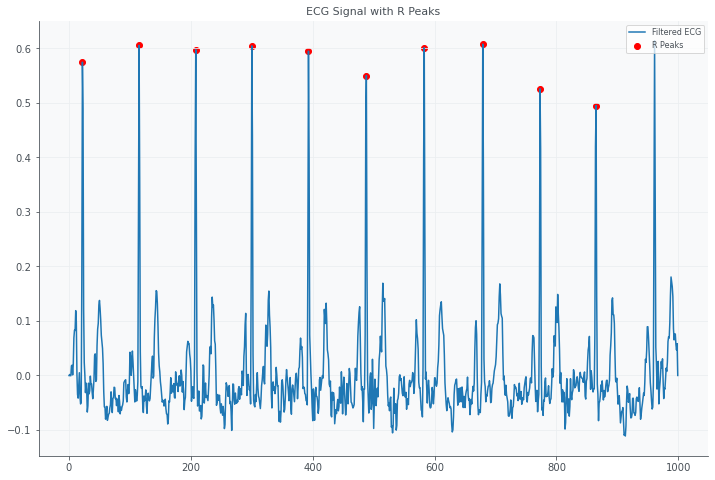

In [28]:
# 心率计算
heart_rate = np.mean(out['heart_rate'])  # 计算平均心率

# 获取波形特征
r_peaks = out['rpeaks']

# 输出一些特征示例
print(f'平均心率: {heart_rate:.2f} bpm')
# 绘图
plt.figure(figsize=(12, 8))
plt.plot(signal, label='Filtered ECG')
plt.scatter(out['rpeaks'], signal[out['rpeaks']], color='red', label='R Peaks')  # 标记R峰
plt.legend()
plt.title('ECG Signal with R Peaks')
plt.show()

P波起始位置: [ 19  95 189 298 391 483 580 672 769 848]
T波结束位置: [ 30 128 217 314 400 500 593 692 778 869]


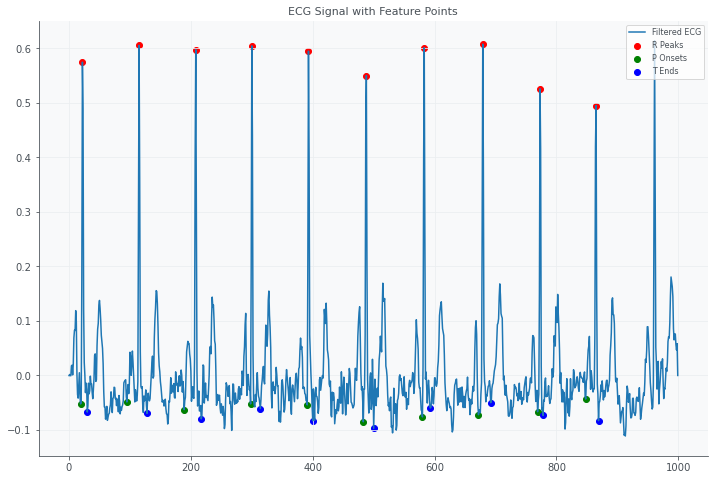

In [30]:
from biosppy.signals import ecg

def find_p_t_waves(signal, r_peaks, sampling_rate):
    # 设置搜索窗口
    p_window = int(0.25 * sampling_rate)  # 约250毫秒的窗口来搜索P波
    t_window = int(0.35 * sampling_rate)  # 约350毫秒的窗口来搜索T波

    p_onsets = []
    t_ends = []

    for r in r_peaks:
        # 搜索P波起点：在R峰之前的窗口内搜索最小点作为P波起始
        p_start = max(0, r - p_window)
        p_end = r
        if p_start < p_end:  # 确保窗口有效
            p_onset = p_start + np.argmin(signal[p_start:p_end])
            p_onsets.append(p_onset)

        # 搜索T波终点：在R峰之后的窗口内搜索最小点作为T波结束
        t_start = r
        t_end = min(len(signal), r + t_window)
        if t_start < t_end:  # 确保窗口有效
            t_end = t_start + np.argmin(signal[t_start:t_end])
            t_ends.append(t_end)

    return np.array(p_onsets), np.array(t_ends)

# 使用BioSPPy进行ECG分析
out = ecg.ecg(signal=filtered_ecg_signals[:, channel_index], sampling_rate=sampling_rate, show=False)

# 找到P波起始和T波终点
p_onsets, t_ends = find_p_t_waves(filtered_ecg_signals[:, channel_index], out['rpeaks'], sampling_rate)

# 输出一些特征
print(f'P波起始位置: {p_onsets}')
print(f'T波结束位置: {t_ends}')

# 绘制信号和标记的特征点
plt.figure(figsize=(12, 8))
plt.plot(signal, label='Filtered ECG')
plt.scatter(out['rpeaks'], signal[out['rpeaks']], color='red', label='R Peaks')  # 标记R峰
plt.scatter(p_onsets, signal[p_onsets], color='green', label='P Onsets')  # 标记P波起始
plt.scatter(t_ends, signal[t_ends], color='blue', label='T Ends')  # 标记T波结束
plt.legend()
plt.title('ECG Signal with Feature Points')
plt.show()


## Rhythm feature

## Save Features

In [32]:
import pandas as pd

# 假设我们已经从上面的代码中获取了以下数据
r_peaks = out['rpeaks']
p_onsets, t_ends = find_p_t_waves(filtered_ecg_signals[:, channel_index], r_peaks, sampling_rate)
heart_rate = np.mean(out['heart_rate'])  # 平均心率

# 计算最大长度
max_length = max(len(r_peaks), len(p_onsets), len(t_ends))

# 将所有数组转换为相同长度的浮点型数组
data = {
    'R_peaks': np.pad(r_peaks.astype(float), (0, max_length - len(r_peaks)), 'constant', constant_values=np.nan),
    'P_onsets': np.pad(p_onsets.astype(float), (0, max_length - len(p_onsets)), 'constant', constant_values=np.nan),
    'T_ends': np.pad(t_ends.astype(float), (0, max_length - len(t_ends)), 'constant', constant_values=np.nan),
    'Heart_Rate': np.full(max_length, heart_rate, dtype=float)  # 使用full创建一个常数数组
}

# 创建DataFrame
df = pd.DataFrame(data)

# 保存DataFrame到CSV文件
csv_file_path = 'ecg_features.csv'
df.to_csv(csv_file_path, index=False)

print(f'特征数据已保存到 "{csv_file_path}"')


特征数据已保存到 "ecg_features.csv"
